In [1]:
import pandas as pd
import numpy as np
import random
from pandas.api.types import CategoricalDtype

### Overall Logic

![ElectricModel_frame](ElectricModel_frame.png)

In [2]:
def excludingfromMNY(df,pct_escooter_N,pct_bicycle_N):
    '''
    [Input]
    df: the input dataframe should be the output df of the commuter model, for now, operations such as adding new columns (MNY_RES) are performed outside/before
    pct_escooter_N: % of Escooter no need to charge in MNY, we can interpret this number as (MNY_RES not EV + non_MNY_RES prefer charge at home)
    pct_bicycle_N: % of E-Bicycle no need to charge in MNY, we can interpret this number as (MNY_RES not EV + non_MNY_RES prefer charge at home)
    ### future: taxi narrow to MNY
    
    [Output]
    series (0,1) indicating whether each line should be exclude from the electric model or not
    excluding: True/1; keep: False/0
    '''
    
    autos_motorcycle_hardcap = (df['HOMEOWNER_LABEL']=='Own') & (df['MNY_RES']==0) & (df['TransMode'].isin(['AutoOccupants','Motorcycle']))
    bus_hardcap = (df['MNY_RES']==0) & (df['TransMode'].isin(['Bus']))

    escooter_flag = df['TransMode'].apply(lambda x: True if random.random() <= pct_escooter_N/100 and x=='Escooter' else False)
    bicycle_flag = df['TransMode'].apply(lambda x: True if random.random() <= pct_bicycle_N/100 and x=='Bicycle' else False)
    
    final_series = autos_motorcycle_hardcap | bus_hardcap | escooter_flag | bicycle_flag
    
    return final_series.astype(int)

In [3]:
def NumberOfEV(row):
    ### For each row, getting the number of EVs
    if row['TransMode'] in ['AutoOccupants','Escooter','Bicycle','Motorcycle','Taxicab']:
        return row['PERWT']
    elif row['TransMode']=='Bus':
        return row['PERWT']/20
    elif row['TransMode']=='Ferry':
        return row['PERWT']/100
    elif row['TransMode'] in ['Subway','CommuterRail']:
        return 1 

    
def TotalEnergyPerEV(row):
    ### For each row, getting the total energy for EACH EV
    if row['TransMode'] in ['AutoOccupants','Escooter','Bicycle','Motorcycle']:
        return row['DISTANCE_KM']*row['Multiplier']*2
    elif row['TransMode'] in ['Bus','Taxicab']:
        return row['DISTANCE_KM']*row['Multiplier']
    elif row['TransMode']=='Ferry':
        return row['Multiplier']
    elif row['TransMode'] in ['Subway','CommuterRail']:
        return row['PERWT']*row['Multiplier']

    
def HourEnergyPerEV(row):
    ### For each row, getting the hourly energy for EACH EV
    ### output are rows with two new columns (type: list): Charge_Hour & Energy
    if row['TransMode'] in ['AutoOccupants','Escooter','Bicycle','Motorcycle','Taxicab','Bus','Ferry']:
        hour = list(range(0,24))*2
        charging_hr_roundup = np.ceil(row['TotalEnergyPerEV']/row['ChargingPower_kW'])
        duration_hr = int(min(charging_hr_roundup,row['HoursToFullyRecharge_hr']))
        energy = int(row['TotalEnergyPerEV']//row['ChargingPower_kW'])*[row['ChargingPower_kW']] + [row['TotalEnergyPerEV']%row['ChargingPower_kW']]
        energy_list = energy[:duration_hr]
    
        if row['TransMode'] in ['AutoOccupants','Escooter','Bicycle','Motorcycle']:
            hour_list = hour[row['HOUR']:int(row['HOUR']+duration_hr)]
            row['Charge_Hour'] = hour_list
            row['Energy'] = energy_list
            return row 
        elif row['TransMode'] in ['Bus','Ferry','Taxicab']:
            delay = 6
            hour_list = hour[row['HOUR']+delay:int(row['HOUR']+delay+duration_hr)]
            row['Charge_Hour'] = hour_list
            row['Energy'] = energy_list
            return row 
        
    elif row['TransMode'] in ['Subway','CommuterRail']:
        hour_list = [row['HOUR']]
        energy_list = [row['TotalEnergyPerEV']]
        row['Charge_Hour'] = hour_list
        row['Energy'] = energy_list
        return row 
    
def floor(row):
    ### For agg energy at hour-mode level, adding floor energy for soecific modes
    if row['TransMode']=='Subway':
        return row['Energy']+subway_floor
    elif row['TransMode']=='CommuterRail':
        return row['Energy']+commuterRail_floor 
    else:
        return row['Energy']

In [4]:
def HourEnergyByMode(df):
    '''
    [Input] df: the inbound or outbound flow dataframe
    [Output] A dataframe shows the agg energy at hour-mode level, data structures: Charge_Hour, TransMode, Energy
    This function wraps up the above four functions: NumberOfEV, TotalEnergyPerEV, HourEnergyPerEV, floor
    '''
    
    df = df.merge(right=electric_reference_table[['TransMode','Multiplier','ChargingPower_kW','HoursToFullyRecharge_hr']], on=["TransMode"], how='inner')
    df['NumberOfEV'] = df.apply(lambda row: NumberOfEV(row), axis=1)
    df['TotalEnergyPerEV'] = df.apply(lambda row: TotalEnergyPerEV(row), axis=1)
    df = df.apply(HourEnergyPerEV, axis=1) ### this step is a little slow
    df = df.explode(['Charge_Hour','Energy'])
    df['Energy'] = df['Energy']*df['NumberOfEV'] ### energy per EV --> energy all EV
    df_agg = df.groupby(by=["Charge_Hour","TransMode"]).agg({"Energy":"sum"}).reset_index()
    df_agg['Energy'] = df_agg.apply(lambda row: floor(row), axis=1)
    return df_agg

### HOW TO RUN

In [5]:
electric_reference_table = pd.read_csv("electric_reference_table.csv")
subway_floor = int(electric_reference_table[electric_reference_table['TransMode']=='Subway']['Floor_kWh'])
commuterRail_floor = int(electric_reference_table[electric_reference_table['TransMode']=='CommuterRail']['Floor_kWh'])
electric_reference_table

,TransMode,ChargingPower_kW,HoursToFullyRecharge_hr,Floor_kWh,Multiplier,MultiplierUnit,excludingfromMNY,NumberOfEV,TotalEnergyPerEV,HourEnergyPerEV,Energy
0,AutoOccupants,12.0,7.0,NaN,0.213400,kwh/km,Live outside of MNY & Owner,PERWT,DISTANCE_KM*Multiplier*2,no delay + related to charging time,In
1,Bus,163.0,3.0,NaN,1.761000,kwh/km,Live outside of MNY,PERWT/20,DISTANCE_KM*Multiplier,6 hr delay + related to charging time,In+Out
2,Ferry,200.0,4.0,NaN,10.000000,kwh,NaN,PERWT/100,Multiplier,6 hr delay + related to charging time,In
3,Escooter,0.3,6.0,NaN,0.046622,kwh/km,% no need to charge in MNY,PERWT,DISTANCE_KM*Multiplier*2,no delay + related to charging time,In
4,Bicycle,0.3,5.0,NaN,0.042403,kwh/km,% no need to charge in MNY,PERWT,DISTANCE_KM*Multiplier*2,no delay + related to charging time,In
5,Motorcycle,3.0,8.0,NaN,0.152297,kwh/km,Live outside of MNY & Owner,PERWT,DISTANCE_KM*Multiplier*2,no delay + related to charging time,In
6,Taxicab,12.0,7.0,NaN,0.213400,kwh/km,NaN,PERWT,DISTANCE_KM*Multiplier,6 hr delay + related to charging time,In+Out
7,Subway,NaN,NaN,55240.0,0.502700,kwh,NaN,1,PERWT*Multiplier,real time,In+Out
8,CommuterRail,NaN,NaN,9147.0,0.240000,kwh,NaN,1,PERWT*Multiplier,real time,In+Out


In [6]:
### read the 00 random result
commuter_df = pd.read_csv("assignment_00_random.csv",index_col=0)

########################################################################################################################
### the next four lines can be deleted if the previous pipeline already fix it
commuter_df['MNY_RES'] = commuter_df['PUMAKEY_HOME'].apply(lambda x: 1 if x.startswith('36_038') else 0)
commuter_df = commuter_df.rename({'Rand Assignment':'TransMode'},axis=1)
commuter_df['LEAVE_WORK_HOUR'] = (commuter_df['ARRIVES_AT_WORK_HOUR'] + commuter_df['HRS_WK_DAILY'])%24
commuter_df['LEAVE_WORK_HOUR'] = commuter_df['LEAVE_WORK_HOUR'].astype(int)
########################################################################################################################

## for easier coding, only take Manhattan workers (dir==in)
commuter_df = commuter_df[commuter_df['COMMUTE_DIRECTION_MANHATTAN']=='in'].reset_index(drop=True)

##############################   
####   excludingfromMNY   ####
##############################

commuter_df['excludingfromMNY'] = excludingfromMNY(commuter_df,pct_escooter_N=20,pct_bicycle_N=20)
commuter_df = commuter_df[commuter_df['excludingfromMNY']==0].reset_index(drop=True)

In [7]:
### getting the inbound or outbound flow dataframe
in_flow = commuter_df[["ARRIVES_AT_WORK_HOUR",'TransMode',"DISTANCE_KM",'PERWT',"MNY_RES"]].rename({'ARRIVES_AT_WORK_HOUR':'HOUR'},axis=1)
out_flow = commuter_df[["LEAVE_WORK_HOUR",'TransMode',"DISTANCE_KM",'PERWT',"MNY_RES"]].rename({'LEAVE_WORK_HOUR':'HOUR'},axis=1)

In [8]:
##############################   
####   HourEnergyByMode   ####
##############################

df_agg_in = HourEnergyByMode(in_flow)
df_agg_out = HourEnergyByMode(out_flow)
df_agg_out = df_agg_out[df_agg_out['TransMode'].isin(['Bus','Subway','CommuterRail','Taxicab'])].reset_index(drop=True)

df_agg = df_agg_in.merge(right=df_agg_out, on=["Charge_Hour","TransMode"], how='outer').fillna(0)
df_agg['Energy'] = df_agg['Energy_x'] + df_agg['Energy_y']

mode_order = CategoricalDtype(['AutoOccupants','Bus','Ferry','Escooter', 'Bicycle','Motorcycle','Taxicab','Subway','CommuterRail'],ordered=True)
df_agg_in['TransMode'] = df_agg_in['TransMode'].astype(mode_order)
df_agg_out['TransMode'] = df_agg_out['TransMode'].astype(mode_order)
df_agg['TransMode'] = df_agg['TransMode'].astype(mode_order)

df_agg

,Charge_Hour,TransMode,Energy_x,Energy_y,Energy
0,0,AutoOccupants,90.988519,0.000000,90.988519
1,0,Bicycle,5191.841650,0.000000,5191.841650
2,0,Bus,628.909793,8186.082715,8814.992507
3,0,Escooter,259.441309,0.000000,259.441309
4,0,Ferry,13.700000,0.000000,13.700000
...,...,...,...,...,...
172,7,Bus,0.000000,1275.752310,1275.752310
173,8,Bus,0.000000,682.223867,682.223867
174,9,Bus,0.000000,558.000901,558.000901
175,10,Bus,0.000000,75.796191,75.796191


In [9]:
df_agg.TransMode.unique()

['AutoOccupants', 'Bicycle', 'Bus', 'Escooter', 'Ferry', 'Motorcycle', 'Subway', 'Taxicab', 'CommuterRail']
Categories (9, object): ['AutoOccupants' < 'Bus' < 'Ferry' < 'Escooter' ... 'Motorcycle' < 'Taxicab' < 'Subway' < 'CommuterRail']

## VIS

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid', palette='Paired', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

### 0. Number of Commuters by Modes

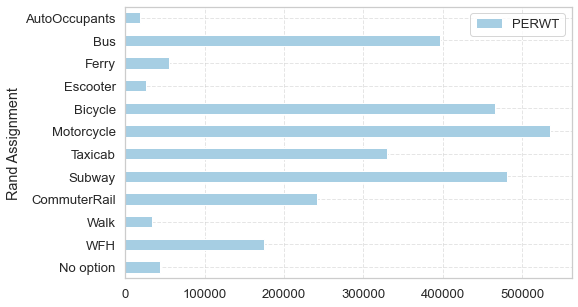

In [11]:
commuter_df = pd.read_csv("assignment_00_random.csv",index_col=0)
mode = commuter_df.groupby(by=["Rand Assignment"]).agg({"PERWT":"sum"}).reset_index()
order = CategoricalDtype(['AutoOccupants','Bus','Ferry','Escooter', 'Bicycle','Motorcycle','Taxicab','Subway','CommuterRail','Walk','WFH','No option'],ordered=True)
mode['Rand Assignment'] = mode['Rand Assignment'].astype(order)
mode.sort_values('Rand Assignment',inplace=True)
mode

fig,(ax1) = plt.subplots(1,1,figsize=(8,5),sharey=True)
plt.grid(ls='--',alpha=0.5)
mode.plot.barh(x='Rand Assignment', y='PERWT', ax=ax1)
plt.gca().invert_yaxis()

### 1. BUS: Within or Exceeding Capacity

The max hourly energy of bus (kWh):  24236
Within capacity


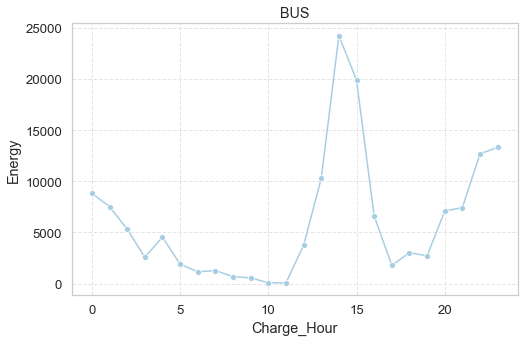

In [12]:
bus = df_agg[df_agg['TransMode']=='Bus'][['Charge_Hour','TransMode','Energy']].sort_values('Charge_Hour').reset_index(drop=True)
bus_max = bus.Energy.max()
fig,(ax1) = plt.subplots(1,1,figsize=(8,5),sharey=True)
plt.grid(ls='--',alpha=0.5)
sns.lineplot(data=bus,x='Charge_Hour',y='Energy',marker='o',ax=ax1)
plt.title('BUS')
print('The max hourly energy of bus (kWh): ', int(bus_max))
if bus_max <= 1457000:   ### 1457 MW = 1457000 kW
    print('Within capacity')
else:
    print('Exceeding capacity')

### 2. Energy Profile

Text(0.5, 1.0, 'Hourly Energy by Modes - all')

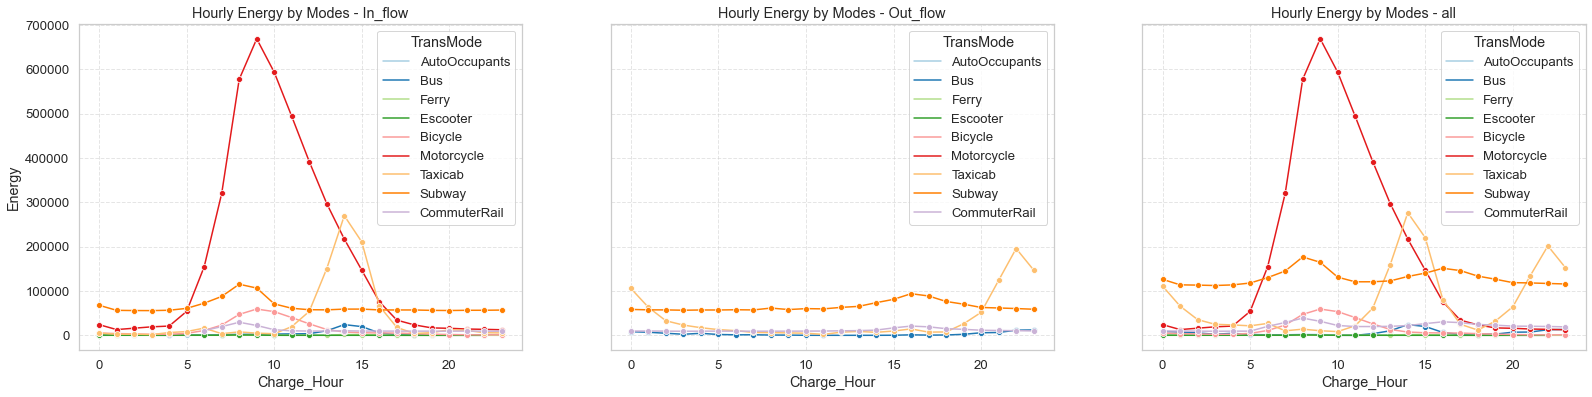

In [13]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(27,6),sharey=True)
ax1.grid(ls='--',alpha=0.5)
ax2.grid(ls='--',alpha=0.5)
ax3.grid(ls='--',alpha=0.5)
sns.lineplot(data=df_agg_in,x='Charge_Hour',y='Energy',marker='o',hue='TransMode',ax=ax1)
ax1.set_title("Hourly Energy by Modes - In_flow")
sns.lineplot(data=df_agg_out,x='Charge_Hour',y='Energy',marker='o',hue='TransMode',ax=ax2)
ax2.set_title("Hourly Energy by Modes - Out_flow")
sns.lineplot(data=df_agg,x='Charge_Hour',y='Energy',marker='o',hue='TransMode',ax=ax3)
ax3.set_title("Hourly Energy by Modes - all")

Text(0.5, 1.0, "Energy Profile of Manttan Workers' Commuting Activities")

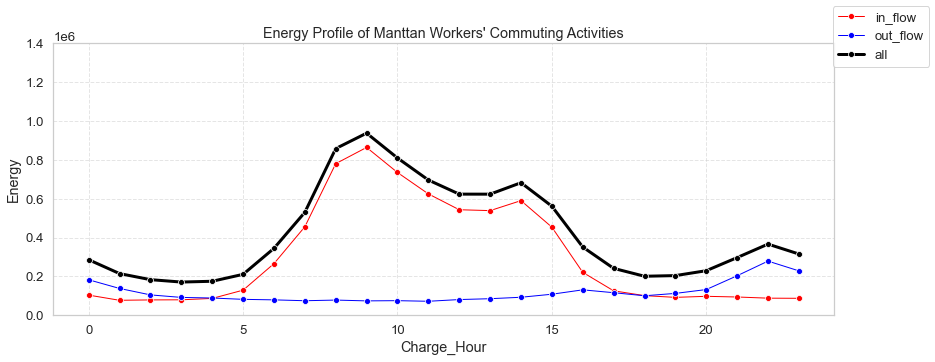

In [14]:
total_in = df_agg_in.groupby(by=["Charge_Hour"]).agg({"Energy":"sum"})
total_out = df_agg_out.groupby(by=["Charge_Hour"]).agg({"Energy":"sum"})
total = df_agg.groupby(by=["Charge_Hour"]).agg({"Energy":"sum"})
fig,(ax1)=plt.subplots(1,1,figsize=(14,5),sharey=True)
plt.grid(ls='--',alpha=0.5)
sns.lineplot(data=total_in,x='Charge_Hour',y='Energy',marker='o',color='red',linewidth=1)
sns.lineplot(data=total_out,x='Charge_Hour',y='Energy',marker='o',color='b',linewidth=1)
sns.lineplot(data=total,x='Charge_Hour',y='Energy',marker='o',color='k',linewidth=3)
fig.legend(labels=['in_flow','out_flow','all'])
ax1.set_ylim(0, 1.4e6)
ax1.set_title("Energy Profile of Manttan Workers' Commuting Activities")

### 3. Traffic Flow

Text(0.5, 1.0, "Manttan Workers' Traffic Flow")

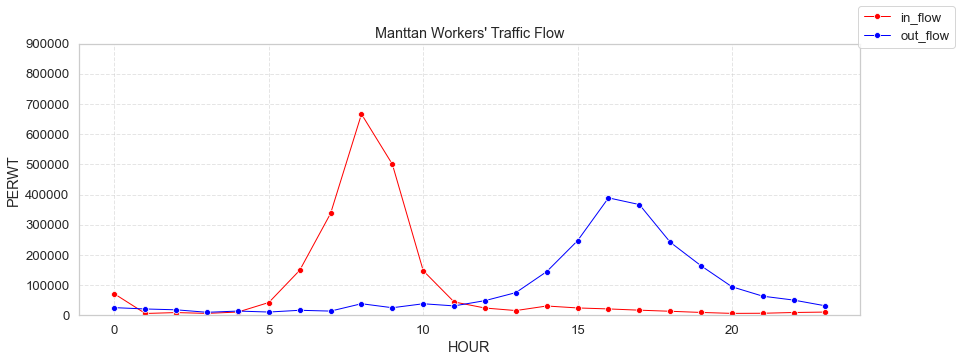

In [15]:
in_ = in_flow.groupby(by=["HOUR"]).agg({"PERWT":"sum"}).reset_index()
out_ = out_flow.groupby(by=["HOUR"]).agg({"PERWT":"sum"}).reset_index()
fig,(ax1)=plt.subplots(1,1,figsize=(14,5),sharey=True)
plt.grid(ls='--',alpha=0.5)
sns.lineplot(data=in_,x='HOUR',y='PERWT',marker='o',color='red',linewidth=1)
sns.lineplot(data=out_,x='HOUR',y='PERWT',marker='o',color='b',linewidth=1)
fig.legend(labels=['in_flow','out_flow'])
ax1.set_ylim(0, 9e5)
ax1.set_title("Manttan Workers' Traffic Flow")